<a href="https://colab.research.google.com/github/Yomex139/Rock_Paper_Scissors-project/blob/main/Rock_Paper_Scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


In [35]:
(test,train),ds_info = tfds.load(name='rock_paper_scissors',
                    shuffle_files=True,
                    download=True,
                    as_supervised=True,
                    with_info=True,
                    split=['test','train'])

In [36]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
})

In [37]:
class_names = ds_info.features['label'].names
class_names

['rock', 'paper', 'scissors']

In [38]:
one_train_sample = train.take(1)
one_train_sample

<TakeDataset shapes: ((300, 300, 3), ()), types: (tf.uint8, tf.int64)>

In [39]:
for image,label in one_train_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from {ds_info.name} (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (300, 300, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from rock_paper_scissors (tensor form): 2
  Class name (str form): scissors
        


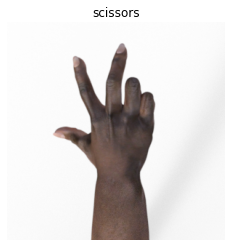

In [40]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis('off');

In [41]:
#download helper functions
!wget https://github.com/Yomex139/Food-Vision/raw/main/Helper_Function.py

--2021-10-19 23:29:36--  https://github.com/Yomex139/Food-Vision/raw/main/Helper_Function.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Yomex139/Food-Vision/main/Helper_Function.py [following]
--2021-10-19 23:29:36--  https://raw.githubusercontent.com/Yomex139/Food-Vision/main/Helper_Function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11521 (11K) [text/plain]
Saving to: ‘Helper_Function.py.1’

Helper_Function.py. 100%[===================>]  11.25K  --.-KB/s    in 0s      

2021-10-19 23:29:36 (51.8 MB/s) - ‘Helper_Function.py.1’ saved [11521/11521]



In [42]:
from Helper_Function import load_and_prep_image,walk_through_dir,bef_train_visual,visualize_after,compare_historys,confusion_matrix,create_tensorboard_callback,plot_loss_curves

In [43]:
#image
#whats needed to be done
#read in the data
#resize image tensors
#turning image tensors from uint8 to float32 and normalize(depends on model to be used)
#also turning to batches using tf.data

In [44]:
tf.reduce_min(image).numpy(),tf.reduce_max(image).numpy()

(25, 255)

In [45]:
#preprocess image(resizing and converting to float)
def preprocessed(image,label):
  '''
  accept an input image and output preprocessed image
  '''
  image = tf.image.resize(image,size=[224,224])
  image = tf.image.convert_image_dtype(image,dtype=tf.float32)
  #image = tf.cast(image,dtype=tf.float32)
  return image,label

image size before preprocessing is:
 (300, 300, 3)

image size after preprocessing is:
 (224, 224, 3)


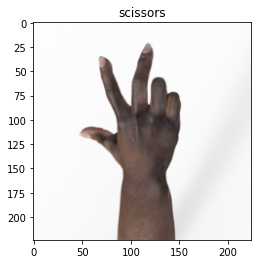

In [46]:
print(f'image size before preprocessing is:\n {image.shape}\n')
img = preprocessed(image,label)[0]
plt.imshow(img/255)
plt.title(class_names[label])
print(f'image size after preprocessing is:\n {img.shape}')

In [47]:
#map preprocess function to train data
train_data = train.map(map_func=preprocessed,num_parallel_calls=tf.data.AUTOTUNE)
#batch and ...... dataset
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
#map preprocess function to train data
test_data = test.map(map_func=preprocessed,num_parallel_calls=tf.data.AUTOTUNE)
#batch and ...... dataset
test_data = test_data.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [48]:
train_data,test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

In [49]:
#create model callbacks(modelcheckpoint,earlycallbacks and tensorboard callbacks)
rock_paper_scissors_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
model_checkpoint_rps = tf.keras.callbacks.ModelCheckpoint(filepath='RPS_Checkpoint/cp.ckpt',
                                                          monitor='val_accuracy',
                                                          save_best_only=True,
                                                          save_weights_only=True)

In [50]:
#setup mix_precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float16')

In [51]:
#cross ckecking
mixed_precision.global_policy()

<Policy "float16">

In [52]:
data_augmentaton = tf.keras.models.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
            tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
            tf.keras.layers.experimental.preprocessing.RandomWidth(.15),
            tf.keras.layers.experimental.preprocessing.RandomContrast(.4)
],name='augmentation_layer')
#setup base model
Base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#set traininable to false
Base_model.trainable = False
#setup input
input = tf.keras.layers.Input(shape=(224,224,3),name='Input_ Layer')
#data_augmentation layer
x = data_augmentaton(input)
#map input to base model
x = Base_model(x,training=False)
#global average pooling
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling_Layer')(x)
#output layer
x = tf.keras.layers.Dense(3,name='Dense_Layer')(x)
#output activation layer
output = tf.keras.layers.Activation(activation='softmax',dtype=tf.float32,name='Activation/Output_Layer')(x)
#build model
model_1 = tf.keras.Model(input,output)

In [53]:
#compile the model
model_1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [54]:
#fit the model
history_1 = model_1.fit(train_data,
            epochs=50,
            validation_data=test_data,
            steps_per_epoch=len(train_data),
            validation_steps=int(.3*len(test_data)),
            callbacks=[rock_paper_scissors_earlystop,model_checkpoint_rps,create_tensorboard_callback(dir_name='RPS_with EfficientnetB0',
                                                                                                      experiment_name='rock_paper_scissors')])

Saving TensorBoard log files to: RPS_with EfficientnetB0/rock_paper_scissors/20211019-232940
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


79/79 [==============================] - 55s 584ms/step - loss: 4.1836 - accuracy: 0.4729 - val_loss: 1.1758 - val_accuracy: 0.4583
Epoch 2/50
79/79 [==============================] - 38s 455ms/step - loss: 0.5645 - accuracy: 0.7998 - val_loss: 0.5391 - val_accuracy: 0.7603
Epoch 3/50
79/79 [==============================] - 36s 404ms/step - loss: 0.3145 - accuracy: 0.8950 - val_loss: 0.3201 - val_accuracy: 0.9165
Epoch 4/50
79/79 [==============================] - 33s 384ms/step - loss: 0.2052 - accuracy: 0.9365 - val_loss: 0.2399 - val_accuracy: 0.9375
Epoch 5/50
79/79 [==============================] - 34s 398ms/step - loss: 0.1549 - accuracy: 0.9570 - val_loss: 0.2167 - val_accuracy: 0.9272
Epoch 6/50
79/79 [==============================] - 34s 391ms/step - loss: 0.1215 - accuracy: 0.9668 - val_loss: 0.2109 - val_accuracy: 0.9272
Epoch 7/50
79/79 [==============================] - 36s 419ms/step - loss: 0.1010 - accuracy: 0.9795 - val_loss: 0.1730 - val_accuracy: 0.9585
Epoch 8/50

In [55]:
loss, accuracy = model_1.evaluate(test_data)
accuracy

12/12 [==============================] - 1s 107ms/step - loss: 0.2211 - accuracy: 0.8711


0.87109375

In [56]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_ Layer (InputLayer)    [(None, 224, 224, 3)]     0         
_________________________________________________________________
augmentation_layer (Sequenti (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
GlobalAveragePooling_Layer ( (None, 1280)              0         
_________________________________________________________________
Dense_Layer (Dense)          (None, 3)                 3843      
_________________________________________________________________
Activation/Output_Layer (Act (None, 3)                 0         
Total params: 4,053,414
Trainable params: 3,843
Non-trainable params: 4,049,571
_____________________________________________

In [57]:
for layer_num,layers in enumerate(model_1.layers):
  print(layer_num,layers.name,layers.trainable)

0 Input_ Layer True
1 augmentation_layer True
2 efficientnetb0 False
3 GlobalAveragePooling_Layer True
4 Dense_Layer True
5 Activation/Output_Layer True


In [58]:
for layer_num,layers in enumerate(Base_model.layers):
  print(layer_num,layers.name,layers.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [59]:
#fine_tuning the base model
#set set base model trainability to True
Base_model.trainable=True

In [60]:
for layer_num,layers in enumerate(Base_model.layers[:-10]):
  print(layer_num,layers.name,layers.trainable)
  layers.trainable=False

0 input_2 True
1 rescaling_1 True
2 normalization_1 True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 b

In [61]:
#setting trainability to false except few layers and checking for base model 4 trainability
for layer_number,layers in enumerate(Base_model.layers[:-15]):
  layers.trainable=False

#re-compile the model(model_3)
model_1.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])


In [62]:

for layer_num,layers in enumerate(Base_model.layers):
  print(layer_num,layers.name,layers.trainable)

0 input_2 False
1 rescaling_1 False
2 normalization_1 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [63]:
initial_epoc = 5
fine_tune_epoch = initial_epoc+45

In [64]:
history_2 = model_1.fit(train_data,
            epochs=fine_tune_epoch,
            validation_data=test_data,
            steps_per_epoch=len(train_data),
            validation_steps=int(.3*len(test_data)),
            initial_epoch=initial_epoc,
            callbacks=[rock_paper_scissors_earlystop,model_checkpoint_rps,create_tensorboard_callback(dir_name='RPS_with EfficientnetB0',
                                                                                                      experiment_name='rock_paper_scissors_fine_tune')])

Saving TensorBoard log files to: RPS_with EfficientnetB0/rock_paper_scissors_fine_tune/20211019-233710
Epoch 6/50


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


79/79 [==============================] - 40s 390ms/step - loss: 0.0249 - accuracy: 0.9937 - val_loss: 0.1494 - val_accuracy: 0.9272
Epoch 7/50
79/79 [==============================] - 25s 282ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 0.2615 - val_accuracy: 0.8960
Epoch 8/50
79/79 [==============================] - 25s 288ms/step - loss: 0.6313 - accuracy: 0.9419 - val_loss: 0.4285 - val_accuracy: 0.9478
Epoch 9/50
79/79 [==============================] - 26s 302ms/step - loss: 0.0245 - accuracy: 0.9937 - val_loss: 0.3652 - val_accuracy: 0.9478
Epoch 10/50
79/79 [==============================] - 26s 296ms/step - loss: 0.0152 - accuracy: 0.9961 - val_loss: 0.6499 - val_accuracy: 0.9062
Epoch 11/50
79/79 [==============================] - 22s 240ms/step - loss: 0.0136 - accuracy: 0.9951 - val_loss: 0.5381 - val_accuracy: 0.9375


In [65]:
model_1.evaluate(test_data)

12/12 [==============================] - 1s 109ms/step - loss: 0.8018 - accuracy: 0.9058


[0.8017578125, 0.90576171875]

In [80]:
model_1.load_weights('RPS_Checkpoint/cp.ckpt')